# Example Aoristic Analysis

This is an example of conducting aoristic analysis. See this [blog post](https://crimede-coder.com/blogposts/2024/Aoristic) for a description and other resources.

In [8]:
from crimeanalysis import data, aoristic, cdcplot
plt = aoristic.plt # just for typical plt

df = data.load_dallas_data()
df.head(1).T

,0
nibrs_cat,1
location,8
begin,2021-07-23 09:45:00
end,2021-07-23 09:54:00
address,2201 N STEMMONS FWY
lat,32.799877
lon,-96.82853
NIBR_DESC,MOTOR VEHICLE THEFT
LOC_DESC,Parking Lot


In [9]:
burg = df[df['nibrs_cat'] == 5].copy()
burg['Type'] = (1*(burg['location'] == 1)).replace({1: 'Residential', 0: 'Commercial'})
print(burg['Type'].value_counts())
burg_aor = aoristic.agg_weekhour(burg,'begin','end',group=['Type'])

# can see that this generates hour by day of week by group in the data
burg_aor

Type
Residential    10424
Commercial      8754
Name: count, dtype: int64


,Type,weight,weekday,hour
0,Commercial,72.926611,0,0
1,Commercial,95.196473,0,1
2,Commercial,129.064980,0,2
3,Commercial,150.222895,0,3
4,Commercial,146.001093,0,4
...,...,...,...,...
331,Residential,60.245929,6,19
332,Residential,59.169821,6,20
333,Residential,69.536057,6,21
334,Residential,55.535867,6,22


findfont: Generic family 'sans-serif' not found because none of the following families were found: Verdana
findfont: Generic family 'sans-serif' not found because none of the following families were found: Verdana
findfont: Generic family 'sans-serif' not found because none of the following families were found: Verdana
findfont: Generic family 'sans-serif' not found because none of the following families were found: Verdana
findfont: Generic family 'sans-serif' not found because none of the following families were found: Verdana
findfont: Generic family 'sans-serif' not found because none of the following families were found: Verdana
findfont: Generic family 'sans-serif' not found because none of the following families were found: Verdana
findfont: Generic family 'sans-serif' not found because none of the following families were found: Verdana
findfont: Generic family 'sans-serif' not found because none of the following families were found: Verdana
findfont: Generic family 'sans-serif'

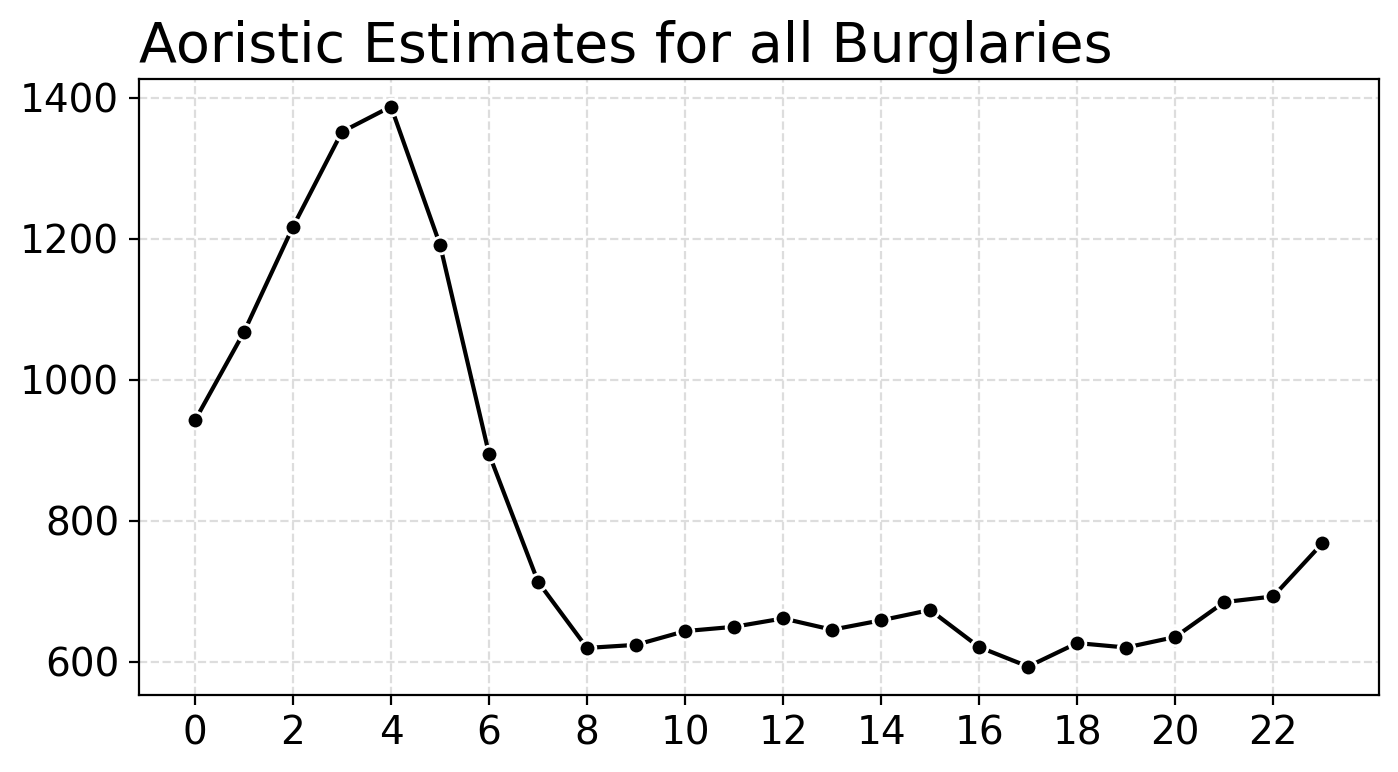

In [10]:
# Now have some helpers

# combining all of the data into just hour of day
b_hour = burg_aor.groupby('hour',as_index=False)['weight'].sum()

# in notebooks, you don't want to use fig.show, so I have show=False here
aoristic.plt_basic(b_hour,show=False,title='Aoristic Estimates for all Burglaries')

In [ ]:
burg_comm = burg_aor[burg_aor['Type'] == 'Commercial'].copy()
burg_resi = burg_aor[burg_aor['Type'] == 'Residential'].copy()

# Can see the pattern is much different for residential!
# Sat/Sun is shifted slightly later in the day
aoristic.plt_super(burg_resi,show=False,title='Residential Burglaries')
aoristic.plt_super(burg_comm,show=False,title='Commercial Burglaries')

In [ ]:
# These functions have helpers to just pass in ax

# Small multiple sharing X
fig, ax = plt.subplots(2,1,figsize=(8,4),sharex=True)
lg = {'bbox_to_anchor':(1.0,0.6), 'fontsize': 8} # legend kwargs
aoristic.plt_super(burg_resi,ax=ax[0],show=False,title='Residential Burglaries',leg_kwargs=lg)
aoristic.plt_super(burg_comm,ax=ax[1],show=False,legend=False,title='Commercial Burglaries')
plt.subplots_adjust(hspace=0.3) # adjusting space between subplots

# Superimposing on the same plot and normalizing to percentages
bc_hour = burg_comm.groupby('hour',as_index=False)['weight'].sum()
bc_hour['weight'] = bc_hour['weight']/bc_hour['weight'].sum()
br_hour = burg_resi.groupby('hour',as_index=False)['weight'].sum()
br_hour['weight'] = br_hour['weight']/br_hour['weight'].sum()

fig, ax = plt.subplots(figsize=(6,3))
aoristic.plt_basic(bc_hour,show=False,ax=ax,color="#286090",label='Commercial',title='Hour of Day Proportion')
aoristic.plt_basic(br_hour,show=False,ax=ax,color="#233A2D",label='Residential')
lr = ax.legend() # assigning object just so don't get annoying output in notebook!

In [ ]:
# Lets look at MV Thefts, since that has been surging
mv = df[df['nibrs_cat'] == 1].copy()

time_dif = mv['end'] - mv['begin']
print('Distribution of time differences in hours')
print( (time_dif.dt.seconds/(60*60)).describe()) # convert to hours
prop_uncertain = (time_dif.dt.seconds > 0).mean()
print(f'\nProportion of MV Thefts with unknown time {prop_uncertain:.2f}')

mv_aor = aoristic.agg_weekhour(mv,'begin','end') # it takes a bit to churn though 90,000+ rows

In [ ]:
# If you must, here is how to make a heatmap style plot
from pylab import cm

# using a discrete colormap is easier to viz than continuous IMO
cmap = plt.get_cmap("PuRd",5)

# pivot the table to wide format
mvp = mv_aor.pivot(index='weekday',columns='hour',values='weight')

fig, ax = plt.subplots(figsize=(7,3))
ax.tick_params(top=True,labeltop=True, bottom=False, labelbottom=False)
im = ax.imshow(mvp,cmap=cmap)
cbar = ax.figure.colorbar(im,ax=ax,location='bottom',pad=0.05)
ax.set_yticks(mvp.index,labels=aoristic.wd_lab)
ax.grid(False)